# Callback Functions
- Considerations during model training
    - Which epoch gave best results
    - When to stop training
    - Frequency for saving model
    - Visualize training process
- TensorFlow uses callback functions to address the considerations
- 3 main ones
    - `ModelCheckpoint`
    - `EarlyStopping`
    - `TensorBoard`

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np
import matplotlib.pylab as plt
from pathlib import Path

import random
tf.random.set_seed(17)
np.random.seed(17)

## Load Dataset

### Preprocessing

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalize to 0-1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Preview Images

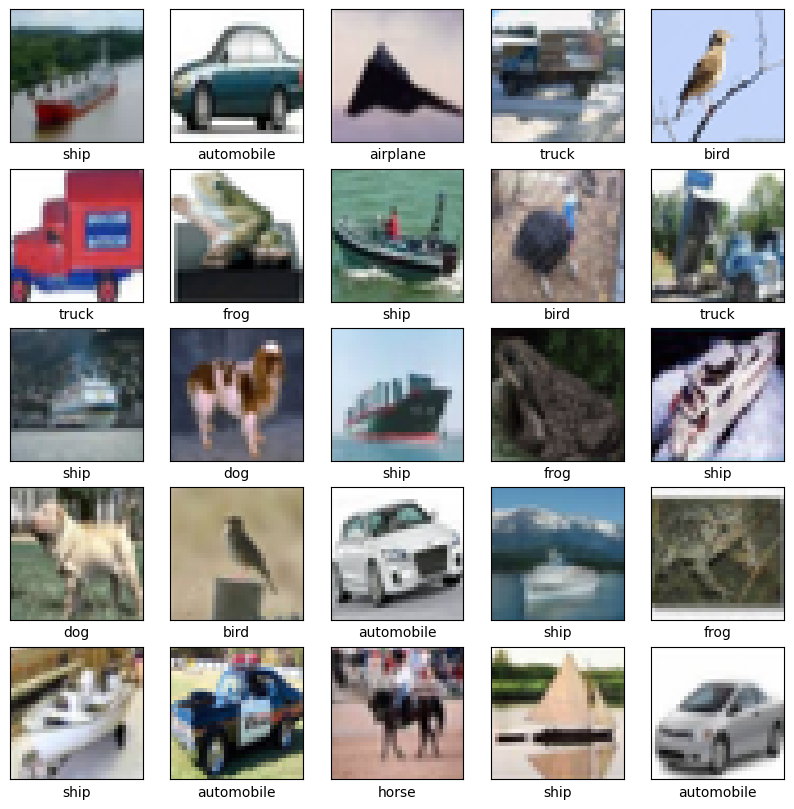

In [3]:
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

train_idx = list(range(len(train_labels)))
random_sample = random.sample(train_idx, 25)

plt.figure(figsize=(10,10))
for i in range(len(random_sample)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_sample[i]], cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[train_labels[random_sample[i]][0]])
plt.show()

## Model

### Train/Val/Test Split
- Split into train/val/test
- Shuffle train dataset
- Batch train, val, and test

In [4]:
# split
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images[:5000], test_labels[:5000]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images[5000:], test_labels[5000:]))

TRAIN_DATASET_SIZE = len(train_dataset)
print(f'Training data sample size: {TRAIN_DATASET_SIZE}')

VALIDATION_DATASET_SIZE = len(validation_dataset)
print(f'Validation data sample size: {VALIDATION_DATASET_SIZE}')

TEST_DATASET_SIZE = len(test_dataset)
print(f'Test data sample size: {TEST_DATASET_SIZE}')

# shuffle
BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(TRAIN_DATASET_SIZE)

# batch
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Training data sample size: 50000
Validation data sample size: 5000
Test data sample size: 5000


### Build Model
- Takes in an input of 32x32x3
- 2 pairs of convolution and max pooling layers
- Flattens into 256 and then 10 nodes

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32,
        kernel_size=(3, 3),
        activation='relu',
        kernel_initializer='glorot_uniform',
        padding='same',
        input_shape=(32, 32, 3)
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(
        64,
        kernel_size=(3, 3),
        activation='relu',
        kernel_initializer='glorot_uniform',
        padding='same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', name='custom_class')
])
model.build([None, 32, 32, 3])

c:\Users\Me\Documents\Projects\LinkedInLearning\Python\TensorFlowCV\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile Model

In [6]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy']
)

## ModelCheckpoint
- [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
- Regularly saves model
    - Typically at the end of a training epoch
- `ModelCheckpoint` only saves if there's been an improvement over the previous epoch
    - Resulting saved model is the best
- Need to specify a directory for each checkpoint
- Our criteria for determining best model is the `val_accuracy`
- Callbacks expect a Python list of the different callback functions

In [7]:
CHECKPOINT_DIR = './cifar10_training_checkpoints'
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / 'checkpoint_{epoch}.keras'
print('Checkpoint Prefix:', CHECKPOINT_PREFIX)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max'
)

callbacks = [
    checkpoint
]

hist = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
).history

Checkpoint Prefix: cifar10_training_checkpoints\checkpoint_{epoch}.keras
Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.2582 - loss: 2.0007 - val_accuracy: 0.4662 - val_loss: 1.5101
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4993 - loss: 1.3831 - val_accuracy: 0.5396 - val_loss: 1.2965
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5765 - loss: 1.1942 - val_accuracy: 0.5766 - val_loss: 1.2126
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.6254 - loss: 1.0657 - val_accuracy: 0.5448 - val_loss: 1.3559
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.6668 - loss: 0.9574 - val_accuracy: 0.5768 - val_loss: 1.2671
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.7016 - loss: 0.8588 - val_accuracy: 0.5800 - val_loss: 1.2646
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.7443 - loss: 0.7402 - val_accuracy: 0.5570 - val_loss: 1.4914
Epoch 8/10
390/39

In [8]:
max_epoch = hist['val_accuracy'].index(max(hist['val_accuracy'])) + 1
print(f"The best model has a validation accuracy of {max(hist['val_accuracy'])} on epoch {max_epoch}")

The best model has a validation accuracy of 0.5799999833106995 on epoch 6


- All of our checkpoints are stored in the specified directory

In [9]:
!ls -lrt ./cifar10_training_checkpoints

total 84000
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:01 checkpoint_1.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:02 checkpoint_2.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:02 checkpoint_3.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:02 checkpoint_4.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:03 checkpoint_5.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:03 checkpoint_6.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:03 checkpoint_7.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:03 checkpoint_8.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:04 checkpoint_9.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:04 checkpoint_10.keras


- To only save model if it's better, we use the `save_best_only` parameter
- The first model checkpoint is always saved
    - Future models are only saved if it improved
    - In our case, a better val accuracy

In [10]:
BEST_CHECKPOINT_DIR = './cifar10_best'
BEST_CHECKPOINT_PREFIX = Path(BEST_CHECKPOINT_DIR) / 'checkpoint_{epoch}.keras'

best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=BEST_CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True # <- only save best model
)

best_callbacks = [
    best_checkpoint
]

best_hist = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=best_callbacks
).history

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8144 - loss: 0.5581 - val_accuracy: 0.5692 - val_loss: 1.7967
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8246 - loss: 0.5236 - val_accuracy: 0.5678 - val_loss: 1.8036
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.8330 - loss: 0.5134 - val_accuracy: 0.5766 - val_loss: 2.0879
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8434 - loss: 0.4874 - val_accuracy: 0.5736 - val_loss: 2.0655
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8270 - loss: 0.5570 - val_accuracy: 0.5426 - val_loss: 2.2475
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8339 - loss: 0.5331 - val_accuracy: 0.5606 - val_loss: 2.2650
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.8593 - loss: 0.4499 - val_accuracy: 0.5000 - val_loss: 2.6235
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8494 - loss: 0.5202 - 

In [11]:
!ls -lrt ./cifar10_best

total 16800
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:04 checkpoint_1.keras
-rw-r--r-- 1 Me 197121 8601187 Jun 13 16:04 checkpoint_3.keras


## EarlyStopping

- [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- Stops training process earlier if mode isn't improving
- Tracks a specified metric
- There are 2 key params
    - `monitor` specifies the metric
    - `patience=n` stops training if the metric doesn't approve after `n` epochs
- Here we track val accuracy and quit after 3 epochs of no improvement

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

callbacks = [
    checkpoint,
    early_stop
]

hist = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks
).history

Epoch 1/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8474 - loss: 0.5303 - val_accuracy: 0.5388 - val_loss: 2.9348
Epoch 2/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8418 - loss: 0.5590 - val_accuracy: 0.5338 - val_loss: 2.6511
Epoch 3/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8430 - loss: 0.5560 - val_accuracy: 0.5688 - val_loss: 2.6268
Epoch 4/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8596 - loss: 0.5014 - val_accuracy: 0.5420 - val_loss: 3.0163
Epoch 5/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8533 - loss: 0.5378 - val_accuracy: 0.5342 - val_loss: 2.7705
Epoch 6/15
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8576 - loss: 0.5113 - val_accuracy: 0.5452 - val_loss: 3.1496


- We stopped at epoch 4 since we haven't had any val accuracy improvements

## TensorBoard
- [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)
- Helps visualize how model params evolve throughout training

### Reset Notebook

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pylab as plt
import random
import datetime
from pathlib import Path

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalize pixel values to be between 0-1
train_images, test_images = train_images / 255.0, test_images / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images[:5000], test_labels[:5000]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images[5000:], test_labels[5000:]))

TRAIN_DATASET_SIZE = len(train_dataset)
print(f'Training data sample size: {TRAIN_DATASET_SIZE}')

VALIDATION_DATASET_SIZE = len(validation_dataset)
print(f'Validation data sample size: {VALIDATION_DATASET_SIZE}')

TEST_DATASET_SIZE = len(test_dataset)
print(f'Test data sample size: {TEST_DATASET_SIZE}')

#Shuffle train datset and batch train, validation and test dataset
BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(TRAIN_DATASET_SIZE).batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Training data sample size: 50000
Validation data sample size: 5000
Test data sample size: 5000


- We use the same model
- Except this time, layers have a `name` property

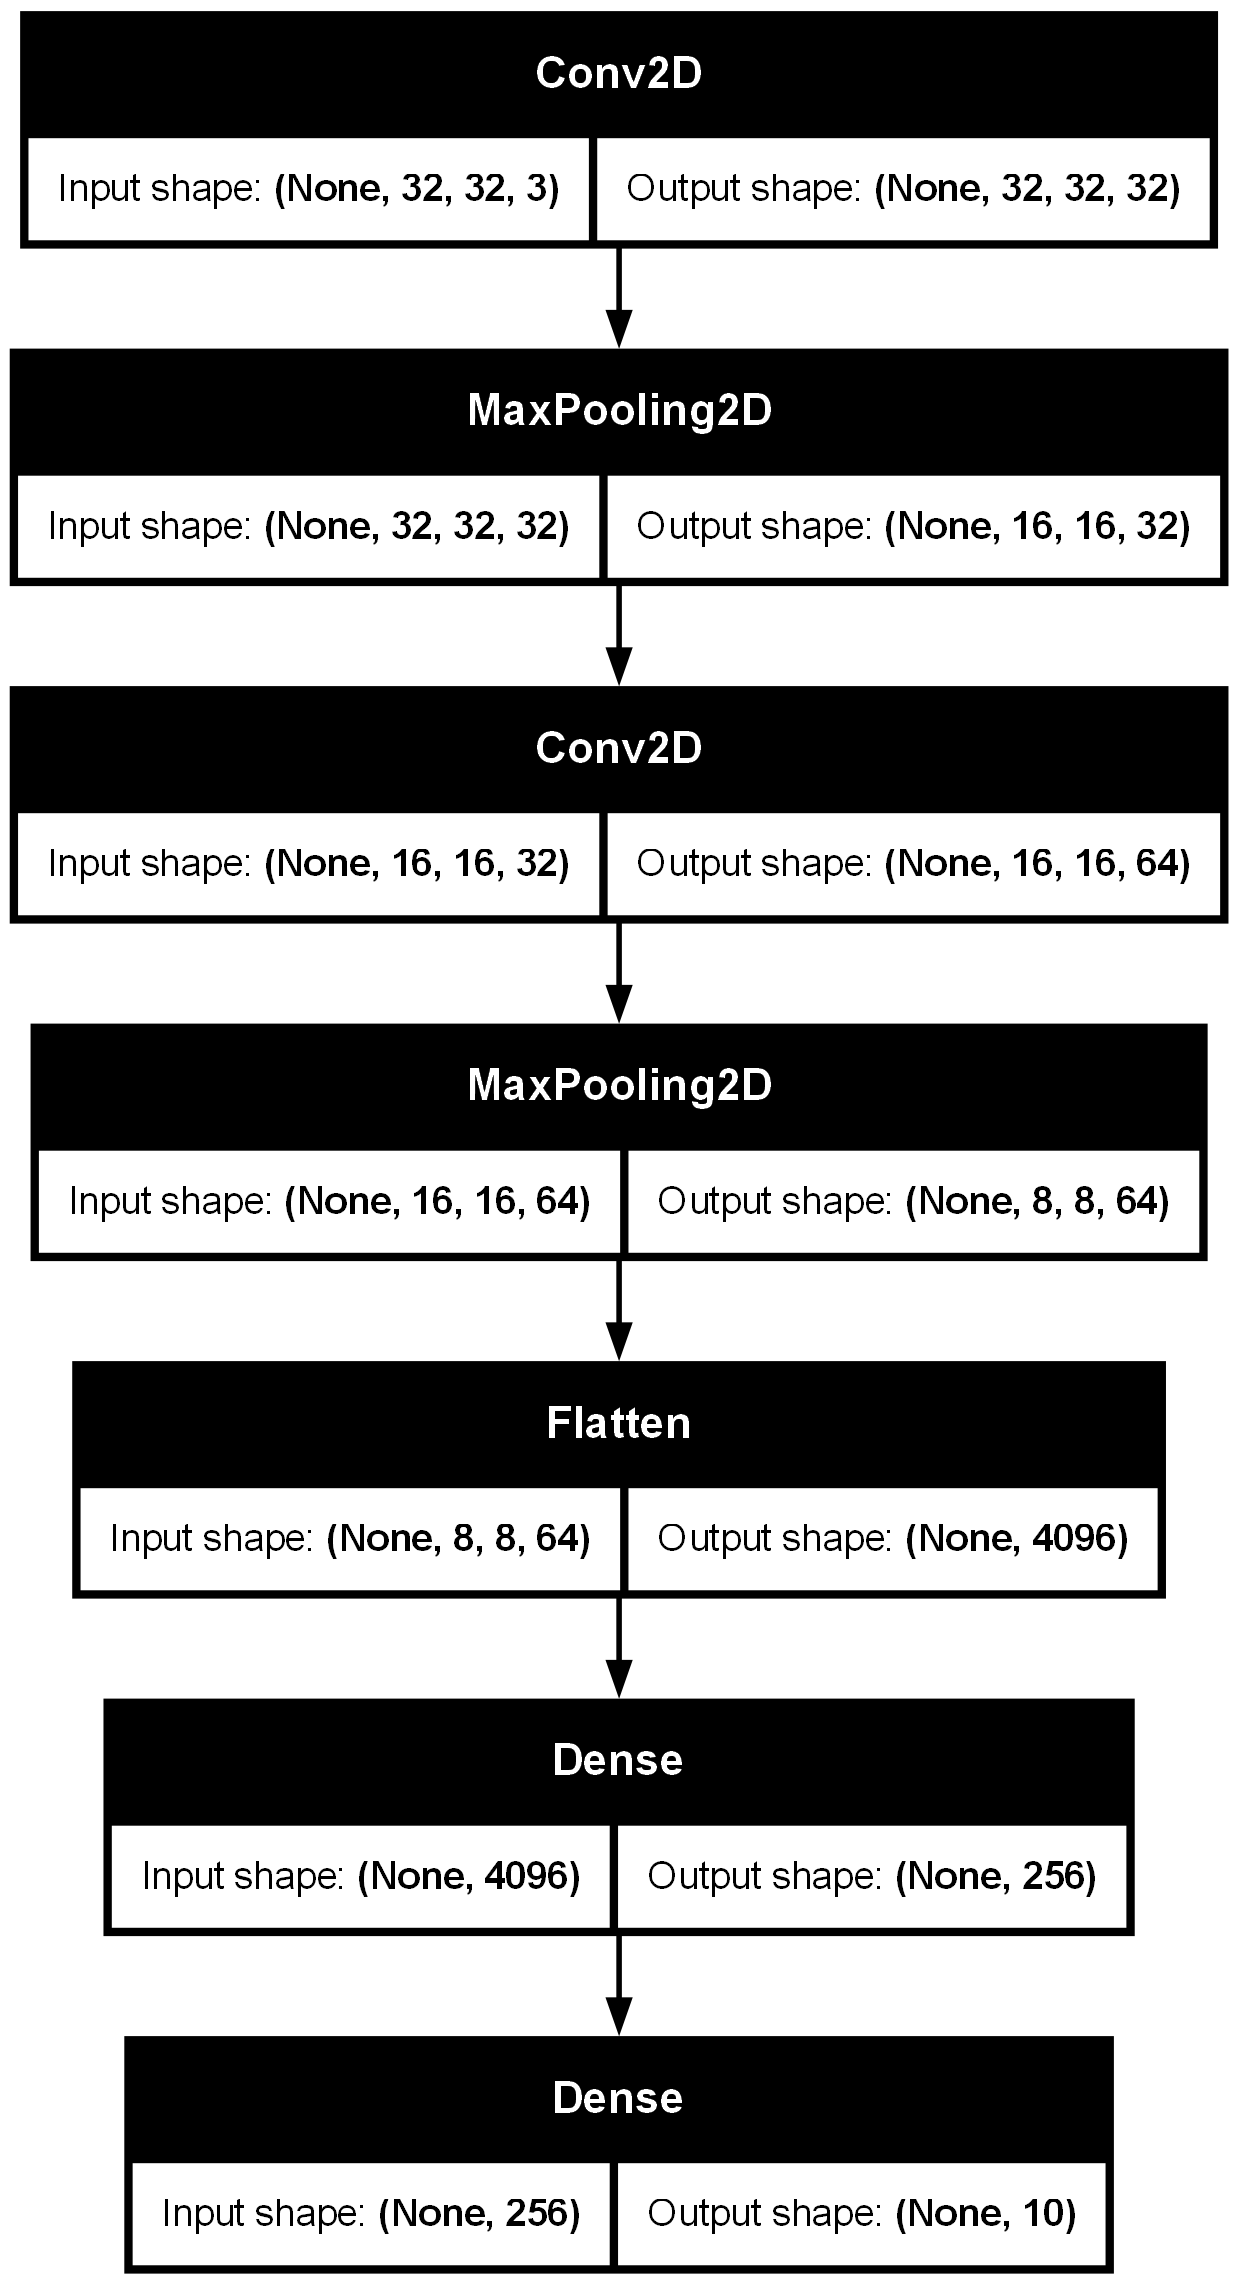

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32,
        kernel_size=(3, 3),
        activation='relu',
        kernel_initializer='glorot_uniform',
        padding='same',
        input_shape=(32, 32, 3),
        name='conv_1'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(
        64,
        kernel_size=(3, 3),
        activation='relu',
        kernel_initializer='glorot_uniform',
        padding='same',
        name='conv_2'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(name='flatten_1'),
    tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='glorot_uniform',
        name='dense_64'
    ),
    tf.keras.layers.Dense(
        10,
        activation='softmax',
        name='dense_10'
    )
])
model.build([None, 32, 32, 3])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=['accuracy']
)

tf.keras.utils.plot_model(model, show_shapes=True)

- TensorBoard params
    - `log_dir` is where to put log files
    - `write_graph` and `write_images` will generate visualizations
    - `histogram_freq=1` means generating a graph after every epoch

In [15]:
MODEL_NAME = f'CIFAR10-{datetime.datetime.now():%Y%m%d-%H%M%S}'
CHECKPOINT_DIR = './' + MODEL_NAME
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / 'checkpoint_{epoch}.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'./tensorboardlogs/{MODEL_NAME}',
    write_graph=True,
    write_images=True,
    histogram_freq=1
)

In [16]:
callbacks = [
    checkpoint,
    tensorboard
]

hist = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks
).history

Epoch 1/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.2994 - loss: 1.9044 - val_accuracy: 0.5176 - val_loss: 1.3686
Epoch 2/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5353 - loss: 1.3043 - val_accuracy: 0.5860 - val_loss: 1.1421
Epoch 3/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6215 - loss: 1.0791 - val_accuracy: 0.6060 - val_loss: 1.1298
Epoch 4/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6747 - loss: 0.9357 - val_accuracy: 0.6294 - val_loss: 1.1011
Epoch 5/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7234 - loss: 0.7913 - val_accuracy: 0.6094 - val_loss: 1.1950
Epoch 6/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7545 - loss: 0.7083 - val_accuracy: 0.6096 - val_loss: 1.2748
Epoch 7/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.7926 - loss: 0.6085 - val_accuracy: 0.6082 - val_loss: 1.3688
Epoch 8/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8151 - loss: 0.5452 - 

In [17]:
%reload_ext tensorboard

In [18]:
%tensorboard --logdir ./tensorboardlogs